## 1. Efficient Net download
Install efficientnet downloaded from github. If using Kaggle, please switch on internet.

In [1]:
# output is hidden in view version
!pip3 install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-jpa30wlk
     |████████████████████████████████| 50 kB 1.4 MB/s eta 0:00:01
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=3e9327974b038e78006d0957fd2891e38dcd25e61a520cef9399f36ae2718f5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q0dk2wrn/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Import packages
<span style = "color:red"> Could we remove the imports that aren't being used? </span>

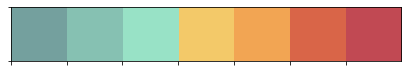

In [2]:
# Regular Imports
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import math
import cv2
import pydicom
import os
import glob
import pickle as pkl
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
from skimage.transform import resize
import copy
import re
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Segmentation
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

# Model imports
import tensorflow as tf 
from tensorflow.keras.layers import (
                                    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D,
                                    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate , Lambda
                                    )
from tensorflow.keras import Model
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
# import tensorflow.keras.applications as tfa
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


pd.set_option("display.max_columns", 100)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

## 3. Tuned Hyperparameters
We define the number of -
* **epochs** : the number of times we loop through the dataset. 
* **batch_size**: how many training examples to feed into network before updating the weights and internal nodes
* **LR**: learning rate
* **MODEL_CLASS**:  allow us to define which efficientnet model we want to use
* **SAVE_BEST**: defined as true, to only save the model due to 'early stopping' implemented

In [3]:
EPOCHS = 40
BATCH_SIZE = 8
NFOLD = 5
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b1'
path = '../input/osic-pulmonary-fibrosis-progression'

## 4. Train-Test split
We create a test dataset with 20% of unique patients and their associated data; 80% for training. 
Duplicates are dropped as some patients have more than one recorded FVC value for each week. 

In [4]:
all_data = pd.read_csv(f'{path}/train.csv') 
all_data.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
unique_patients = all_data.Patient.unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train = all_data[all_data['Patient'].isin(train_ids)]
test = all_data[all_data['Patient'].isin(test_ids)]

## 5. Data Preprocessing
The original features of the data included Age, Smoking_Status, Sex, Weeks, Percent. However, we would like to transform the data, and include altered features. 

The features that will be fed into the model eventually include:
* baseline Age (numerical)
* baseline Percent (numerical)
* Gender (encoded)
* Smoking status (encoded)

Along with that, the numerical data is normalised and categorical variables are one-hot encoded.

In [5]:
def get_baseline_week(df):    
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    _df['min_week'] = _df['Weeks']
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return pd.DataFrame(_df)

In [6]:
train = get_baseline_week(train)
#train = get_baseline_FVC_new(train)
test = get_baseline_week(test)
#test = get_baseline_FVC_new(test)

In [7]:
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week', 'FVC']
num_attribs = ['Percent', 'Age']
cat_attribs = ['Sex', 'SmokingStatus']

In [8]:
from sklearn import preprocessing

num_attribs_scld = [s + '_scld' for s in num_attribs]

min_max_scaler = preprocessing.MinMaxScaler()
train[num_attribs_scld] = min_max_scaler.fit_transform(train[num_attribs])
test[num_attribs_scld] = min_max_scaler.transform(test[num_attribs])

In [9]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,0,0.202489,0.789474
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,9,0.181129,0.789474
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,11,0.148772,0.789474
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,13,0.166325,0.789474
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,15,0.150464,0.789474


In [10]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
80,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
81,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
82,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
83,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
84,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947


Encoding our categorical variables. 
* Gender: Male: 0, Female: 1
* Smoking_Status: Never Smoked: [0,0], Ex-Smoker: [1,1], Currently Smokes: [0,1]


In [11]:
def get_tab_scaled(df): #getting scaled variables
    vector = [df.Age_scld.values[0]] # only the first percent value is retained, so this forms the "base_percent"
    if df.Sex.values[0].lower() == 'male':
        vector.append(0)
    else:
        vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0]) # what is the purpose of this, there arent any other values smoking_status can take?
    return np.array(vector)

We need to create the labels i.e y values for our dataset. We aim to predict the rate of FVC values deterioration, which would be the gradient of a linear regression model fit to every available patient. 

In [12]:
A = {} # Gradient of the linear regression of FVC against weeks 
TAB = {} # Initialize tabular data for each patient
P = [] # Patient IDs

# for all 140 train patients we compute the gradient 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values    
    weeks = sub.Weeks.values 
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab_scaled(sub)
    # TAB[p] = get_tab_unscaled(sub)
    P.append(p)

For each sliced ct scan, we need to resize into 512x512 pixel dimensions. 

In [13]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

There are patients (labelled with BAD_IDs ( <span style = "color:red"> why are they bad_IDs maybe we need to explain that ? </span> )) that need to be removed from the training data. This class also transforms the dataframes into the required numpy arrays so that our data can be input into the neural network. 

In [14]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID] # all the patients in the keys  
        self.a = a # gradients found by fitting a linear regression model
        self.tab = tab # tabular data for patient specified in keys
        self.batch_size = batch_size
        
        self.train_data = {} # initialise a dictionary to contain all the images pertaining to one key: patient id 
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000 # 1000 batches per epoch
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chosen n patients for one batch  
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

## 7. Model Definition

In [17]:
def get_efficientnet(model, shape):
    '''
    From https://github.com/qubvel/efficientnet
    EfficientNet is a CNN architecture achieving state of the art accuracy.
    b0 is the simplest model, b7 is the most complex.
    '''
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False), # We use a b1 efficientnet
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x2) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp, inp2], y)
    return model

## 8. Model Training

We split the dataset into 5 folds for cross validation purposes. There is early stopping employed in the model and the loss function that we decided upon is RMSE = Root Mean Squared Error. It is a commonly used loss function in regression problems.  <span style = "color:red"> do we need to change mse in the code to rmse ? </span>

In [18]:
kf = KFold(n_splits=NFOLD, random_state=42,shuffle=False)
P = np.array(P)
subs = []
folds_history = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(P)):
    print('#####################')
    print('####### Fold %i ######'%fold)
    print('#####################')
    print('Training...')
    
    er = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-3,
        patience=8,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    cpt = tf.keras.callbacks.ModelCheckpoint(
        filepath='fold-%i.h5'%fold,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=SAVE_BEST,
        mode='auto'
    )

    rlp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=5, 
        verbose=1, 
        min_lr=1e-8
    )
    model = build_model(model_class=MODEL_CLASS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse") 
    history = model.fit_generator(IGenerator(keys=P[tr_idx], 
                                   a = A, 
                                   tab = TAB), 
                        steps_per_epoch = 32,
                        validation_data=IGenerator(keys=P[val_idx], 
                                   a = A, 
                                   tab = TAB),
                        validation_steps = 16, 
                        callbacks = [cpt, rlp], 
                        epochs=EPOCHS)
    folds_history.append(history.history)
    print('Training done!')

#####################
####### Fold 0 ######
#####################
Training...
Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 70.1550
Epoch 00001: val_loss improved from inf to 79983440.00000, saving model to fold-0.h5
32/32 [==============================] - 18s 555ms/step - loss: 70.1550 - val_loss: 79983440.0000
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 54.8713
Epoch 00002: val_loss improved from 79983440.00000 to 143744.56250, saving model to fold-0.h5
32/32 [==============================] - 16s 487ms/step - loss: 54.8713 - val_loss: 143744.5625
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 39.4601
Epoch 00003: val_loss improved from 143744.56250 to 497.31488, saving model to fold-0.h5
32/32 [==============================] - 16s 496ms/step - loss: 39.4601 - val_loss: 497.3149
Epoch 4/40
32/32 [==============================] - ETA: 0s - loss: 46.7848
Epoch 00004: val_loss did not improve from 497.31488
32/32 [===

## 9. Validation Loss examination

In [19]:
min_array = []
for i in range(5):
    min_array.append(min(folds_history[i]['val_loss']))
    print(i, min(folds_history[i]['val_loss']))
print(min(min_array))

0 32.44245529174805
1 16.161312103271484
2 25.880266189575195
3 17.301340103149414
4 22.345998764038086
16.161312103271484


In [20]:
# We pick the best model (weights) based on cross validation score.
if SAVE_BEST:
    mean_val_loss = np.mean([np.min(h['val_loss']) for h in folds_history])
else:
    mean_val_loss = np.mean([h['val_loss'][-1] for h in folds_history])
print('Our mean CV MAE is: ' + str(mean_val_loss))

Our mean CV MAE is: 22.826274490356447


min_fold finds out which fold gives the least validation loss

In [21]:
min_fold = np.argmin([np.min(h['val_loss']) for h in folds_history])

In [22]:
min_fold

1

^print what is the fold that gives min loss, keep a record below 

In [23]:
################################
# min_fold = 1 #change accordingly
################################
#uncomment for using notebook

1. download the weights from the output and save to zip file and upload them 
2. Restart kernel at this point for fitting weights from best fold to model in model building

building model for prediction

## 10. Model for Test Data

In [25]:
def build_pred_model(shape=(512, 512, 1), model_class=None, fold=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x2) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp, inp2], y)
    
    # Take from kaggle  working output
    weights = [w for w in os.listdir('./') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    model.load_weights('./' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    
    #take weights from uploaded weights
    #uncomment when using notebook, instead of when committing notebook
    #weights = [w for w in os.listdir('../input/scaled-weights-genderagepercentsmoker/') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    #model.load_weights('../input/scaled-weights-genderagepercentsmoker/' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    return model
#models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]
#uncomment the above to build model from the weights trained above, else can use the below code for building model
models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]

In [1]:
subs = []
q = 0.5
weeks = list(range(-12, 134))
predictions = []
for model in models:
    metric = []
    
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15: # what is this? only certain slices are being extracted for patients?
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                tab.append(get_tab_scaled(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        print(len(test[test.Patient == p])) # number of fvc values to predict for every week
        tab = np.array(tab) 
        print("number of patient data is: ", len(tab))
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) # Predict from all image data and tabular data.
        a = np.quantile(_a, q) # Get the value at the 50th percentile
        
        A_test[p] = a
        print("number of patient FVC data is: ", len(test.FVC.values[test.Patient == p])) # number of times patient takes
        #######################################################################################################################################
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p] #to find the y intercept   #
        #######################################################################################################################################
        print("B_test[p] is: ", B_test[p])
        #B_test is actually to find the intercept
        
        #P_test[p] = test.Percent_scld.values[test.Patient == p] 
        #print("P_test[p] is: ", P_test[p])
        #WEEK[p] = test.baselined_week_scld.values[test.Patient == p]
        #print("WEEK[p] is: ", WEEK[p])
    
    for p in test.Patient.unique():
        for w in weeks:
            patient_prediction = {}
            fvc = A_test[p] * w + B_test[p]  #y = mx + c, A_test[p] = gradient of progression for patient p, w = week_num, B_test[p] is the calculated y_intercept
            print("fvc is: ", fvc)
            patient_prediction = {
                'Week': w,
                'Patient': p,
                'FVC': np.sum(fvc)/len(fvc)
            }
            predictions.append(patient_prediction)
print('done!')

NameError: name 'models' is not defined

In [2]:
predictions

[]

In [28]:
# GET RESULTS INTO A DATAFRAME 
predictions_df = pd.DataFrame(predictions)
# predictions_df.to_csv("test_predictions_GAPS_scaled.csv")

pred_patients are unique patientID of patients in the predictions 

In [29]:
pred_patients  = predictions_df.Patient.unique()

In [30]:
predictions_df.rename(columns = {'Week': 'Weeks'}, inplace = True)

In [31]:
merged_data = pd.merge(predictions_df, test, on = ['Patient', 'Weeks'], how = 'inner')

In [32]:
merged_data 

,Weeks,Patient,FVC_x,FVC_y,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,-3,ID00023637202179104603099,1527.684593,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
1,3,ID00023637202179104603099,1500.614115,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
2,5,ID00023637202179104603099,1491.590622,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
3,7,ID00023637202179104603099,1482.567129,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
4,9,ID00023637202179104603099,1473.543636,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...
307,21,ID00421637202311550012437,2801.456878,2820,84.471603,68,Male,Ex-smoker,15,6,0.422836,0.500000
308,23,ID00421637202311550012437,2794.842955,2853,85.460101,68,Male,Ex-smoker,15,8,0.431144,0.500000
309,29,ID00421637202311550012437,2775.001188,2716,81.356338,68,Male,Ex-smoker,15,14,0.396654,0.500000
310,41,ID00421637202311550012437,2735.317654,2833,84.861011,68,Male,Ex-smoker,15,26,0.426109,0.500000


In [33]:
rmse = np.sqrt((1/len(merged_data)) * sum(np.square(merged_data.FVC_x - merged_data.FVC_y)))  #change this part for non_scaled

In [3]:
# 144.413 (for pyotrch part 2 rmse)
# around 142 for this version
rmse

NameError: name 'rmse' is not defined

In [ ]:
#rmse for unscaled notebook with percent included = 143.2077201851251